In [1]:
import pandas as pd
pd.set_option('display.max_rows', 200)  # or 1000
from scipy.stats import zscore

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import seaborn as sns
import plotly.graph_objects as go

import pingouin as pg
import statsmodels.formula.api as smf
import dabest

import warnings
warnings.filterwarnings('ignore')

/Users/Oliver/miniconda3/envs/hippnac/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/Oliver/miniconda3/envs/hippnac/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Load files

Download data from https://zenodo.org/doi/10.5281/zenodo.10698564

In [2]:
comps = pd.read_feather('FOLDER/comps.feather')
C = pd.read_hdf('FOLDER/C.h5', 'C')
S = pd.read_hdf('FOLDER/S.h5', 'S')
behaviour = pd.read_hdf('FOLDER/behaviour.h5', 'behaviour')

behaviour

Time_s  Lap    Position  Velocity_ds  Velocity_Kalman  Pump  \
ExpID Frame                                                                 
100   0      231.039    1   78.226634          NaN        -0.000256   0.0   
      1      231.104    1   78.226634     0.000000        -0.000219   0.0   
      2      231.169    1   78.226634     0.000000        -0.000174   0.0   
      3      231.234    1   78.226634     0.000000        -0.000129   0.0   
      4      231.299    1   78.226634     0.000000        -0.000089   0.0   
...              ...  ...         ...          ...              ...   ...   
166   8995   347.436   20  115.002524    35.889211              NaN   0.0   
      8996   347.469   20  116.032307    31.288030              NaN   0.0   
      8997   347.502   20  116.971227    28.527322              NaN   0.0   
      8998   347.535   20  117.879859    27.607085              NaN   0.0   
      8999   347.568   20  118.803635    28.067204              NaN   0.0   

              Licking  PositionBin  LickEnvelope  Licks  Licking_smoothed  \
ExpID Frame                                                                 
100   0      0.000048            9      0.000000  False               NaN   
      1      0.000066            9      0.000000  False               NaN   
      2      0.000060            9      0.000000  False               NaN   
      3      0.000022            9      0.000000  False               NaN   
      4      0.000050            9      0.000000  False               NaN   
...               ...          ...           ...    ...               ...   
166   8995   0.008281           14      0.032188  False               NaN   
      8996   0.009525           14      0.030926  False               NaN   
      8997   0.010837           14      0.029641  False               NaN   
      8998   0.012056           14      0.028322  False               NaN   
      8999   0.012584           14      0.026962  False               NaN   

             LickLog  
ExpID Frame           
100   0        False  
      1        False  
      2        False  
      3        False  
      4        False  
...              ...  
166   8995     False  
      8996     False  
      8997     False  
      8998     False  
      8999     False  

[189000 rows x 12 columns]

# Figure 3C

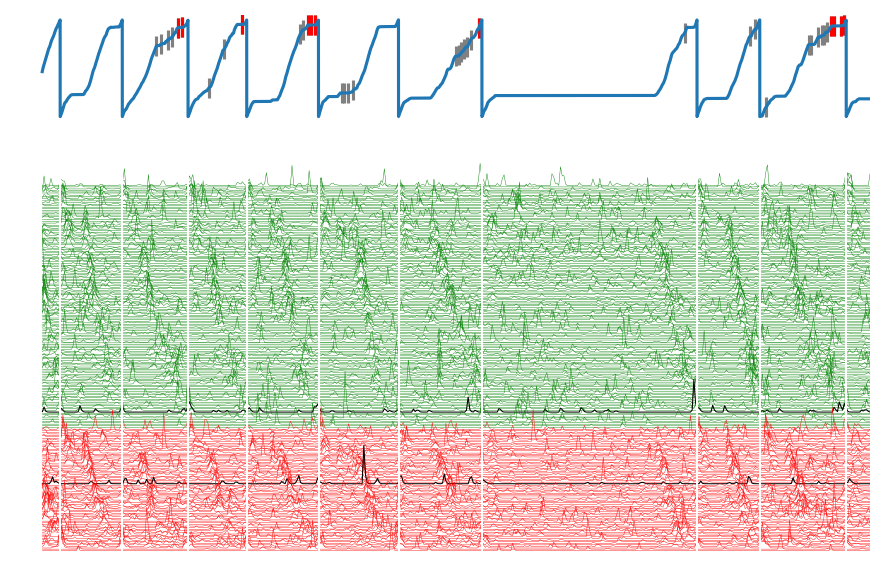

In [3]:
# sample spatial coding
expID = 152
behaviour_exp = behaviour.loc[expID]
C_exp = C[expID]
comps_exp = comps.loc[comps.ExpID==expID].reset_index(drop=True)

C_exp['Time_s'] = round(behaviour_exp['Time_s'])
S_ds = C_exp.groupby('Time_s').mean().T
S_ds['ComAngle'] = comps_exp['ComAngle']
S_ds['Red'] = comps_exp['Red']
S_ds = S_ds.sort_values(['Red', 'ComAngle']).drop('ComAngle', axis=1)

fig, axs = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [1,4]})

behaviour_exp['Reward_Licking'] = 0
behaviour_exp.loc[(behaviour_exp.Position>330)&(behaviour_exp.Licks==1), 'Reward_Licking'] = 1

sns.lineplot(data=behaviour_exp, x='Time_s', y='Position', ax=axs[0])
axs[0].scatter(x=behaviour_exp.loc[behaviour_exp.Licks==1, 'Time_s'], y=behaviour_exp.loc[behaviour_exp.Licks==1, 'Position'], c='gray', alpha=1, marker='|', s=100)
axs[0].scatter(x=behaviour_exp.loc[behaviour_exp.Reward_Licking==1, 'Time_s'], y=behaviour_exp.loc[behaviour_exp.Reward_Licking==1, 'Position'], c='red', alpha=1, marker='|', s=100)

for cell in range(S_ds.shape[0]):
    if cell==145 or cell==191:
        axs[1].plot(S_ds.iloc[cell, :-1]*3-cell*2, linewidth=.5, color='k')
    else:
        axs[1].plot(S_ds.iloc[cell, :-1]*3-cell*2, linewidth=.2, color='g' if S_ds.iloc[cell, -1]==0 else 'r')
for i in behaviour_exp.loc[behaviour_exp.Position.diff().abs()>350, 'Time_s'].to_list():
    axs[1].axvline(i, c='w', lw=1)

axs[0].axis('off');
axs[1].axis('off');
fig.tight_layout()
plt.xlim([320, 820]);


# Figure 3D-E

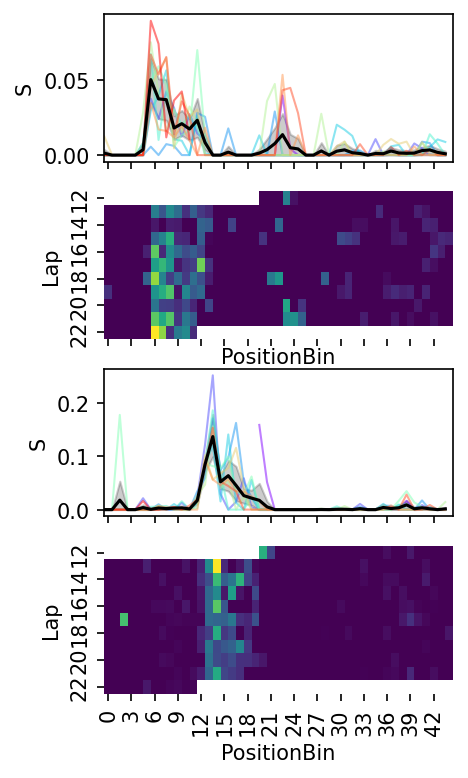

In [4]:
expID = 152
cellIDs = [191, 145]

S_exp = S[expID]#.apply(lambda x: x/max(x))  # norm
behaviour_exp = behaviour.loc[expID]
behaviour_exp['Time_bins'] = round(behaviour_exp.Time_s)
behaviour_exp['PositionBin'] = pd.cut(behaviour_exp.Position, 45, labels=False)
S_PosBin = S_exp.groupby(['Lap', 'PositionBin']).mean()

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(3, 6))
for i, neuronOI in enumerate(cellIDs):
    sample_df = pd.DataFrame({'S': S_PosBin[neuronOI]}).reset_index()
    sample_df['S_gauss'] = sample_df.S.rolling(5, win_type='gaussian').mean(std=2)
    sample_pivot = sample_df.pivot(index='Lap', columns='PositionBin', values='S')
    sample_pivot_gauss = sample_df.pivot(index='Lap', columns='PositionBin', values='S_gauss')
    sns.heatmap(data=sample_pivot, cmap='viridis', ax=axs[i*2+1], cbar=False)
    sns.lineplot(data=sample_df, x='PositionBin', y='S', hue='Lap', estimator=None, units='Lap', palette='rainbow', alpha=.5, lw=1, ax=axs[i*2], legend=None)
    sns.lineplot(data=sample_df, x='PositionBin', y='S', ax=axs[i*2], color='k')
    

# Figure 3F-K

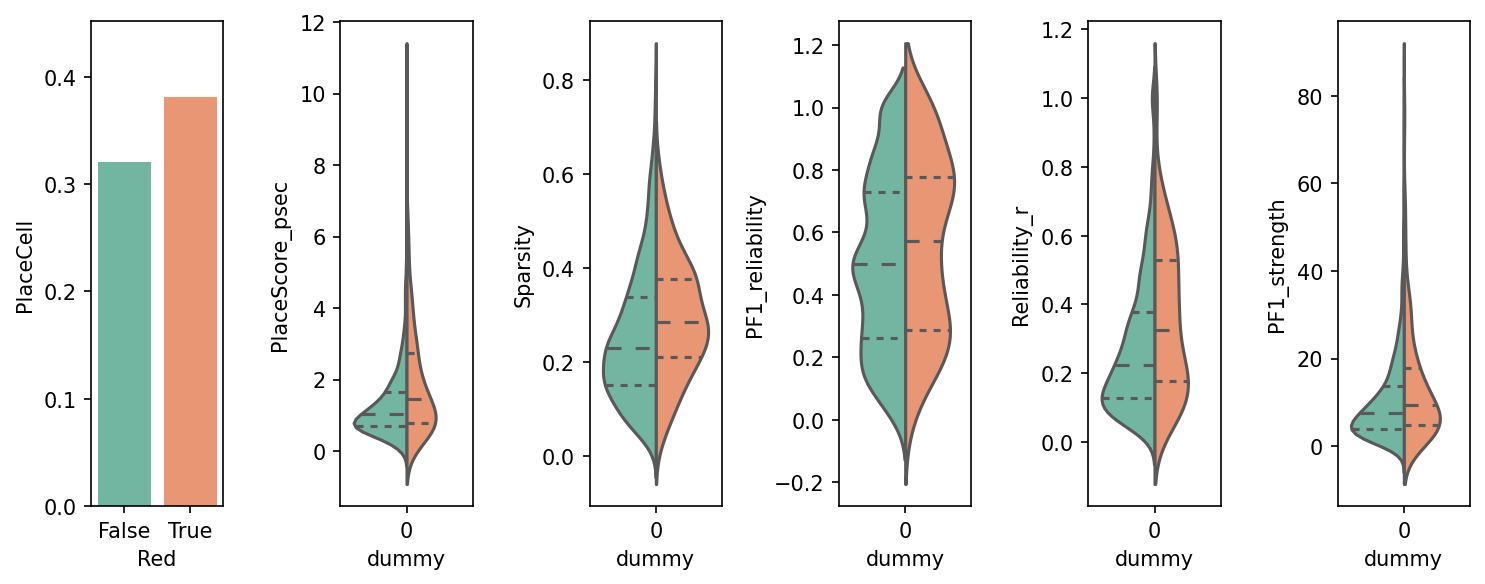

In [5]:
comps['RedC'] = 'Green'
comps.loc[comps.Red==1, 'RedC'] = 'Red'

fig, axs = plt.subplots(1, 6, figsize=(10,4))
comps['dummy'] = 0

sns.barplot(data=comps, x='Red', y='PlaceCell', palette='Set2', ax=axs[0], errwidth=0)
sns.violinplot(data=comps.loc[comps.PlaceCell], hue='Red', x='dummy', y='PlaceScore_psec', palette='Set2', 
               split=True, inner="quart", fill=False, ax=axs[1], legend=False)
sns.violinplot(data=comps.loc[comps.PlaceCell], hue='Red', x='dummy', y='Sparsity', palette='Set2', 
               split=True, inner="quart", fill=False, ax=axs[2])
sns.violinplot(data=comps.loc[comps.PlaceCell], hue='Red', x='dummy', y='PF1_reliability', palette='Set2', 
               split=True, inner="quart", fill=False, ax=axs[3])
sns.violinplot(data=comps.loc[comps.PlaceCell], hue='Red', x='dummy', y='Reliability_r', palette='Set2', 
               split=True, inner="quart", fill=False, ax=axs[4])
sns.violinplot(data=comps.loc[comps.PlaceCell], hue='Red', x='dummy', y='PF1_strength', palette='Set2', 
               split=True, inner="quart", fill=False, ax=axs[5])

fig.tight_layout()

for ax in axs:
    ax.legend([],[], frameon=False)

## Stats F

In [6]:
# Stats D: Proportion place cells
pg.chi2_independence(comps, x='Red', y='PlaceCell')

(PlaceCell        False         True
 Red                                
 False      3322.638868  1605.361132
 True        299.361132   144.638868,
 PlaceCell   False    True
 Red                      
 False      3346.5  1581.5
 True        275.5   168.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  6.364290  1.0  0.011644  0.034420  0.713215
 1        cressie-read  0.666667  6.313584  1.0  0.011982  0.034282  0.709777
 2      log-likelihood  0.000000  6.218098  1.0  0.012645  0.034022  0.703211
 3       freeman-tukey -0.500000  6.151477  1.0  0.013130  0.033839  0.698561
 4  mod-log-likelihood -1.000000  6.088967  1.0  0.013603  0.033667  0.694145
 5              neyman -2.000000  5.975715  1.0  0.014504  0.033352  0.686012)

In [7]:
placecells_red_mouse = pd.DataFrame(comps.groupby(['Mouse', 'Red']).mean()['PlaceCell']).pivot_table(index='Red', columns='Mouse')
placecells_red_mouse.drop(placecells_red_mouse.columns[2], axis=1, inplace=True)
placecells_red_mouse

PlaceCell                                        
Mouse     207.0     208.0     210.0     211.0     212.0
Red                                                    
False  0.487923  0.058824  0.295863  0.328085  0.195122
True   0.500000  0.000000  0.227273  0.372832  0.000000

In [8]:
from scipy.stats import chi2_contingency
chi2_contingency(placecells_red_mouse.T)

(0.24009936669500237,
 0.9933456003388045,
 4,
 array([[0.54718735, 0.44073535],
        [0.03258098, 0.02624255],
        [0.28975264, 0.23338302],
        [0.38822197, 0.31269573],
        [0.1080735 , 0.08704845]]))

In [9]:
comps['PlaceCellN'] = comps.PlaceCell.astype(int)
placecells = dabest.load(comps, idx=("Green", "Red"), x='RedC', y='PlaceCellN', resamples=5000, proportional=True)
placecells.cohens_h.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Green,Red,4928,444,Cohen's h,None,0.125444,95,0.030135,0.225897,0.0116,0.01304,-2.491266,0.01,-2.57673,0.010014,1028582.0


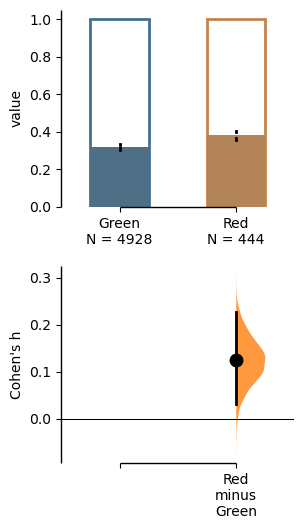

In [10]:
placecells.cohens_h.plot(float_contrast=False);

## Stats G

In [11]:
comps.loc[(comps.PlaceCell), ['Red', 'PlaceScore_psec']].groupby('Red').describe().round(2)

PlaceScore_psec                                           
                count  mean   std   min   25%   50%   75%    max
Red                                                             
False          1581.0  1.31  1.00  0.05  0.69  1.04  1.64  10.95
True            169.0  1.85  1.41  0.09  0.79  1.46  2.73   6.67

In [12]:
pg.normality(comps.loc[(comps.PlaceCell), 'PlaceScore_psec'])

,W,pval,normal
PlaceScore_psec,0.799039,4.097397e-42,False


In [13]:
pg.mwu(comps.loc[(comps.PlaceCell)&(comps.Red==1), 'PlaceScore_psec'], 
         comps.loc[(comps.PlaceCell)&(comps.Red==0), 'PlaceScore_psec'])

,U-val,alternative,p-val,RBC,CLES
MWU,161846.0,two-sided,0.000006,-0.211472,0.605736


In [14]:
lmm_inter = smf.mixedlm("PlaceScore_psec ~ Red", comps.loc[comps.PlaceCell], groups=comps.loc[comps.PlaceCell, "Mouse"],
                        re_formula="~1").fit()
print(lmm_inter.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: PlaceScore_psec
No. Observations: 1750    Method:             REML           
No. Groups:       5       Scale:              1.0624         
Min. group size:  1       Log-Likelihood:     -2543.6570     
Max. group size:  775     Converged:          Yes            
Mean group size:  350.0                                      
--------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        1.340     0.157  8.549  0.000   1.033   1.647
Red[T.True]      0.364     0.087  4.201  0.000   0.194   0.533
Group Var        0.079     0.111                              



In [15]:
placescores = dabest.load(comps.loc[(comps.PlaceCell)], idx=("Green", "Red"), x='RedC', y='PlaceScore_psec', resamples=5000)
placescores.median_diff.statistical_tests.round(8)

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_kruskal,statistic_kruskal
0,Green,Red,1581,169,median difference,None,0.416377,95,0.056772,0.614841,0.0,0.000006,20.471966


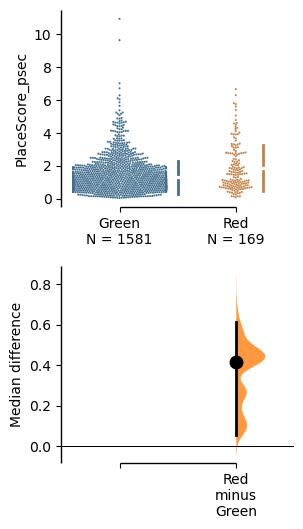

In [16]:
placescores.median_diff.plot(float_contrast=False, raw_marker_size=1.5);

## Stats H

In [17]:
comps.loc[(comps.PlaceCell), ['Red', 'Sparsity']].groupby('Red').describe().round(2)

Sparsity                                          
         count  mean   std   min   25%   50%   75%   max
Red                                                     
False   1581.0  0.26  0.14  0.02  0.15  0.23  0.34  0.81
True     169.0  0.29  0.12  0.03  0.21  0.29  0.38  0.62

In [18]:
pg.normality(comps.loc[(comps.PlaceCell), 'Sparsity'])

,W,pval,normal
Sparsity,0.952096,1.738972e-23,False


In [19]:
pg.mwu(comps.loc[(comps.PlaceCell)&(comps.Red==1), 'Sparsity'], 
         comps.loc[(comps.PlaceCell)&(comps.Red==0), 'Sparsity'])

,U-val,alternative,p-val,RBC,CLES
MWU,160810.0,two-sided,0.000013,-0.203717,0.601859


In [20]:
lmm_inter = smf.mixedlm("Sparsity ~ Red", comps.loc[comps.PlaceCell], groups=comps.loc[comps.PlaceCell, "Mouse"],
                        re_formula="~1").fit()
print(lmm_inter.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Sparsity 
No. Observations: 1750    Method:             REML     
No. Groups:       5       Scale:              0.0173   
Min. group size:  1       Log-Likelihood:     1050.3026
Max. group size:  775     Converged:          Yes      
Mean group size:  350.0                                
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.339    0.060 5.674 0.000  0.222  0.456
Red[T.True]    0.056    0.011 5.077 0.000  0.034  0.078
Group Var      0.016    0.090                          



In [21]:
sparsity = dabest.load(comps.loc[(comps.PlaceCell)], idx=("Green", "Red"), x='RedC', y='Sparsity', resamples=5000)
sparsity.median_diff.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_kruskal,statistic_kruskal
0,Green,Red,1581,169,median difference,None,0.055918,95,0.036386,0.071934,0.0002,0.000013,18.998056


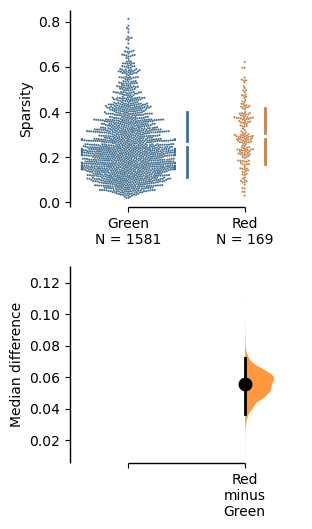

In [22]:
sparsity.median_diff.plot(float_contrast=False, raw_marker_size=1.5);

## Stats I

In [23]:
comps.loc[(comps.PlaceCell), ['Red', 'PF1_reliability']].groupby('Red').describe().round(2)

PF1_reliability                                        
                count  mean   std  min   25%   50%   75%  max
Red                                                          
False          1580.0  0.50  0.28  0.0  0.26  0.50  0.73  1.0
True            169.0  0.56  0.29  0.0  0.29  0.57  0.78  1.0

In [24]:
pg.normality(comps.loc[(comps.PlaceCell), 'PF1_reliability'])

,W,pval,normal
PF1_reliability,0.961911,4.996830e-21,False


In [25]:
pg.mwu(comps.loc[(comps.PlaceCell)&(comps.Red==1), 'PF1_reliability'], 
         comps.loc[(comps.PlaceCell)&(comps.Red==0), 'PF1_reliability'])

,U-val,alternative,p-val,RBC,CLES
MWU,149324.5,two-sided,0.011211,-0.118452,0.559226


In [26]:
lmm_inter = smf.mixedlm("PF1_reliability ~ Red", comps[comps['PF1_reliability'].notna()].loc[comps.PlaceCell], 
                        groups=comps[comps['PF1_reliability'].notna()].loc[comps.PlaceCell, "Mouse"],
                        re_formula="~1").fit()
print(lmm_inter.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: PF1_reliability
No. Observations: 1749    Method:             REML           
No. Groups:       5       Scale:              0.0720         
Min. group size:  1       Log-Likelihood:     -190.9352      
Max. group size:  775     Converged:          Yes            
Mean group size:  349.8                                      
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.504     0.044  11.336  0.000   0.416   0.591
Red[T.True]    -0.009     0.022  -0.391  0.696  -0.053   0.035
Group Var       0.007     0.024                               



In [27]:
reliability = dabest.load(comps.loc[(comps.PlaceCell)], idx=("Green", "Red"), x='RedC', y='PF1_reliability', resamples=5000)
reliability.median_diff.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_kruskal,statistic_kruskal
0,Green,Red,1580,169,median difference,None,0.071429,95,0.0,0.166667,0.0146,0.011208,6.432028


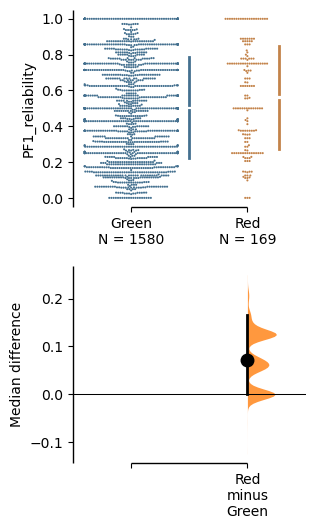

In [28]:
reliability.median_diff.plot(float_contrast=False, raw_marker_size=1.5);

## Stats J

In [29]:
comps.loc[(comps.PlaceCell), ['Red', 'Reliability_r']].groupby('Red').describe().round(2)

Reliability_r                                         
              count  mean   std   min   25%   50%   75%  max
Red                                                         
False        1581.0  0.28  0.20  0.03  0.13  0.23  0.38  1.0
True          169.0  0.36  0.22  0.04  0.18  0.33  0.53  1.0

In [30]:
pg.normality(comps.loc[(comps.PlaceCell), 'Reliability_r'])

,W,pval,normal
Reliability_r,0.889481,1.176623e-33,False


In [31]:
pg.mwu(comps.loc[(comps.PlaceCell)&(comps.Red==1), 'Reliability_r'], 
         comps.loc[(comps.PlaceCell)&(comps.Red==0), 'Reliability_r'])

,U-val,alternative,p-val,RBC,CLES
MWU,162556.0,two-sided,0.000004,-0.216787,0.608393


In [32]:
comps.loc[(comps.PlaceCell)].groupby('Red').describe()['Reliability_r']

,count,mean,std,min,25%,50%,75%,max
Red,,,,,,,,
False,1581.0,0.278776,0.199060,0.026625,0.128433,0.225389,0.376838,1.0
True,169.0,0.357173,0.222048,0.037587,0.176722,0.326003,0.527943,1.0


In [33]:
lmm_inter = smf.mixedlm("Reliability_r ~ Red", comps[comps['Reliability_r'].notna()].loc[comps.PlaceCell], 
                        groups=comps[comps['Reliability_r'].notna()].loc[comps.PlaceCell, "Mouse"],
                        re_formula="~1").fit()
print(lmm_inter.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Reliability_r
No. Observations: 1750    Method:             REML         
No. Groups:       5       Scale:              0.0293       
Min. group size:  1       Log-Likelihood:     590.8771     
Max. group size:  775     Converged:          Yes          
Mean group size:  350.0                                    
------------------------------------------------------------
               Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept      0.250     0.058  4.323  0.000   0.137   0.364
Red[T.True]    0.011     0.014  0.739  0.460  -0.018   0.039
Group Var      0.014     0.066                              



In [34]:
reliabilityR = dabest.load(comps.loc[(comps.PlaceCell)], idx=("Green", "Red"), x='RedC', y='Reliability_r', resamples=5000)
reliabilityR.median_diff.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_kruskal,statistic_kruskal
0,Green,Red,1581,169,median difference,None,0.100614,95,0.051018,0.171357,0.0,0.000004,21.513954


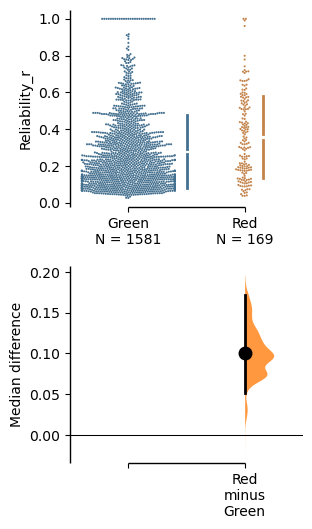

In [35]:
reliabilityR.median_diff.plot(float_contrast=False, raw_marker_size=1.5);

## Stats K

In [36]:
comps.loc[(comps.PlaceCell), ['Red', 'PF1_strength']].groupby('Red').describe().round(2)

PF1_strength                                              
             count   mean    std   min   25%   50%    75%    max
Red                                                             
False       1580.0  10.42   9.58 -1.70  3.91  7.64  13.74  87.58
True         169.0  13.24  12.34  0.21  4.72  9.29  17.88  75.42

In [37]:
pg.normality(comps.loc[(comps.PlaceCell), 'PF1_strength'])

,W,pval,normal
PF1_strength,0.808408,2.155477e-41,False


In [38]:
pg.mwu(comps.loc[(comps.PlaceCell)&(comps.Red==1), 'PF1_strength'], 
         comps.loc[(comps.PlaceCell)&(comps.Red==0), 'PF1_strength'])

,U-val,alternative,p-val,RBC,CLES
MWU,150460.0,two-sided,0.006604,-0.126957,0.563478


In [39]:
comps.loc[(comps.PlaceCell)].groupby('Red').describe()['PF1_strength']

,count,mean,std,min,25%,50%,75%,max
Red,,,,,,,,
False,1580.0,10.415062,9.583013,-1.702969,3.909435,7.638361,13.740459,87.584764
True,169.0,13.235892,12.339592,0.206576,4.724001,9.288823,17.884335,75.417879


In [40]:
lmm_inter = smf.mixedlm("PF1_strength ~ Red", comps[comps['PF1_strength'].notna()].loc[comps.PlaceCell], 
                        groups=comps[comps['PF1_strength'].notna()].loc[comps.PlaceCell, "Mouse"],
                        re_formula="~1").fit()
print(lmm_inter.summary())


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: PF1_strength
No. Observations: 1749    Method:             REML        
No. Groups:       5       Scale:              94.1613     
Min. group size:  1       Log-Likelihood:     -6458.7373  
Max. group size:  775     Converged:          Yes         
Mean group size:  349.8                                   
-----------------------------------------------------------
             Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    10.706     1.123  9.535  0.000   8.506  12.907
Red[T.True]   1.178     0.814  1.446  0.148  -0.418   2.774
Group Var     4.188     0.426                              



In [41]:
strength = dabest.load(comps.loc[(comps.PlaceCell)], idx=("Green", "Red"), x='RedC', y='PF1_strength', resamples=5000)
strength.median_diff.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_kruskal,statistic_kruskal
0,Green,Red,1580,169,median difference,None,1.650462,95,-0.301574,3.544522,0.022,0.006603,7.378003


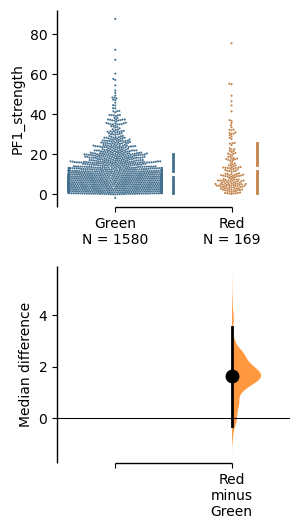

In [42]:
strength.median_diff.plot(float_contrast=False, raw_marker_size=1.5);

# Figure S4

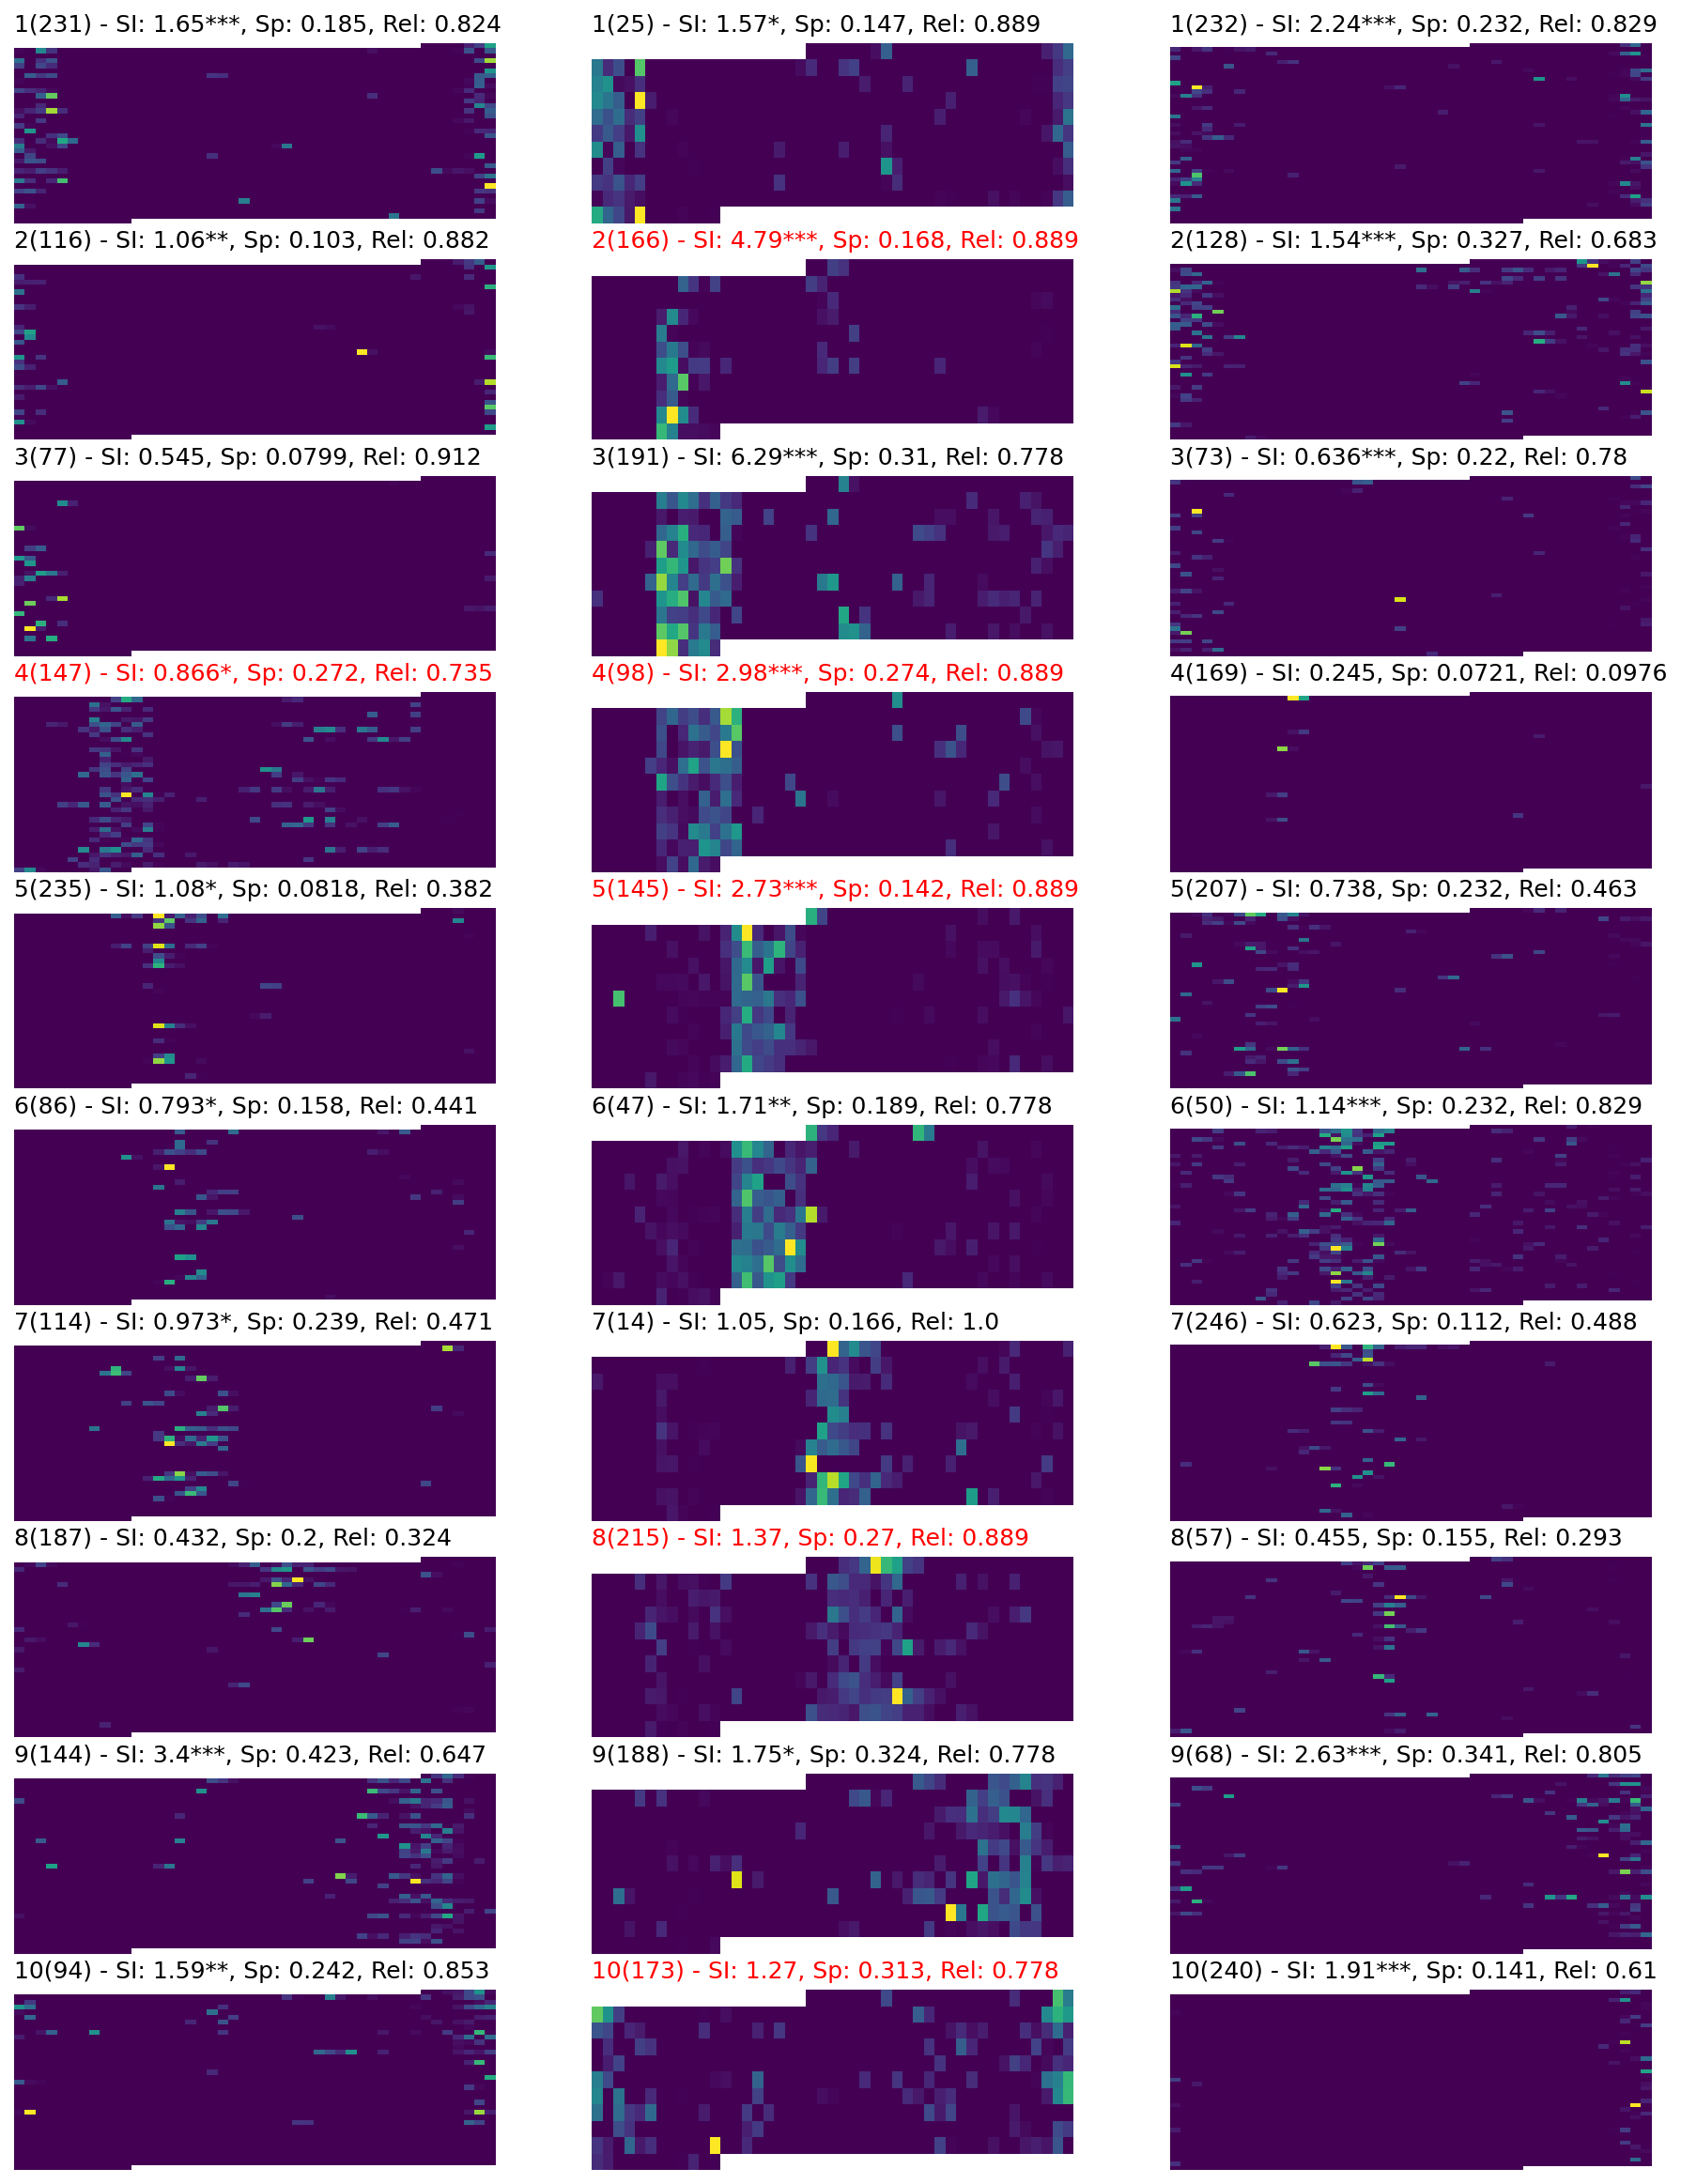

In [43]:
cellIDs = {103: [231, 116, 77, 147, 235, 86, 114, 187, 144, 94],
            137: [232, 128, 73, 169, 207, 50, 246, 57, 68, 240],
            152: [25, 166, 191, 98, 145, 47, 14, 215, 188, 173]}

fig, axs = plt.subplots(10, 3, sharex=True, figsize=(15, 20))
sample_dfs = []

for j, expID in enumerate([103, 152, 137]):
    S_exp = S[expID].apply(lambda x: x/max(x))  # norm
    behaviour_exp = behaviour.loc[expID]
    behaviour_exp['Time_bins'] = round(behaviour_exp.Time_s)
    S_PosBin = S_exp.groupby(['Lap', 'PositionBin']).mean()
    comps_exp = comps.loc[comps.ExpID==expID].reset_index(drop=True)

    for i, neuronOI in enumerate(cellIDs[expID]):
        sample_df = pd.DataFrame({'S': S_PosBin[neuronOI]}).reset_index()
        sample_df['ExpID'] = expID
        sample_df['NeuronID'] = neuronOI
        sample_dfs.append(sample_df)
        # sample_df['S_gauss'] = sample_df.S.rolling(5, win_type='gaussian').mean(std=2)
        sample_pivot = sample_df.pivot(index='Lap', columns='PositionBin', values='S')
        sns.heatmap(data=sample_pivot, cmap='viridis', ax=axs[i, j], cbar=False)
        if comps_exp.loc[neuronOI,'PlaceScoreShufflingPercentile']<=95:
            spacesig = ''
        elif comps_exp.loc[neuronOI,'PlaceScoreShufflingPercentile']<=99:
            spacesig = '*'
        elif comps_exp.loc[neuronOI,'PlaceScoreShufflingPercentile']<100:
            spacesig = '**'
        else:
            spacesig = '***'
        if comps_exp.loc[neuronOI, 'Red']:
            axs[i, j].set_title(f"{i+1}({neuronOI}) - SI: {comps_exp.loc[neuronOI, 'PlaceScore_psec']:{1}.{3}}{spacesig}, Sp: {comps_exp.loc[neuronOI, 'Sparsity']:{1}.{3}}, Rel: {comps_exp.loc[neuronOI, 'PF1_reliability']:{1}.{3}}", loc='left', color='r')#, Rel: {comps_exp.loc[neuronOI, 'PF1_reliability']:{1}.{3}}")
        else:
            axs[i, j].set_title(f"{i+1}({neuronOI}) - SI: {comps_exp.loc[neuronOI, 'PlaceScore_psec']:{1}.{3}}{spacesig}, Sp: {comps_exp.loc[neuronOI, 'Sparsity']:{1}.{3}}, Rel: {comps_exp.loc[neuronOI, 'PF1_reliability']:{1}.{3}}", loc='left')#, Rel: {comps_exp.loc[neuronOI, 'PF1_reliability']:{1}.{3}}")
        axs[i, j].xaxis.set_visible(False)
        axs[i, j].yaxis.set_visible(False)
    


# Fig S3

In [44]:
for exp in comps.ExpID.unique():
    comps.loc[comps.ExpID==exp, 'COM_x_z'] = zscore(comps.loc[comps.ExpID==exp, 'COM_x'])
    comps.loc[comps.ExpID==exp, 'COM_y_z'] = zscore(comps.loc[comps.ExpID==exp, 'COM_y'])

In [45]:
fig = go.Figure()
fig.add_trace(go.Histogram2dContour(
        x = comps.loc[comps.Red==0, "COM_x_z"],
        y = comps.loc[comps.Red==0, "COM_y_z"],
        colorscale = 'Greens_r',
        reversescale = True,
        xaxis = 'x',
        yaxis = 'y',
        opacity = 1,
    ))
fig.add_trace(go.Scatter(
        x = comps.loc[comps.Red==0, "COM_x_z"],
        y = comps.loc[comps.Red==0, "COM_y_z"],
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker = dict(
            color = 'green',
            size = 3,
            opacity = 0.3
        )
    ))
fig.add_trace(go.Scatter(
        x = comps.loc[comps.Red==1, "COM_x_z"],
        y = comps.loc[comps.Red==1, "COM_y_z"],
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker = dict(
            color = 'red',
            size = 3,
            opacity = 0.3
        )
    ))
fig.add_trace(go.Histogram(
        y = comps.loc[comps.Red==0, "COM_y_z"],
        xaxis = 'x2',
        marker = dict(
            color = 'green',
            opacity = 0.5
        )
    ))
fig.add_trace(go.Histogram(
        x = comps.loc[comps.Red==0, "COM_x_z"],
        yaxis = 'y2',
        marker = dict(
            color = 'green',
            opacity = 0.5
        )
    ))
fig.add_trace(go.Histogram(
        y = comps.loc[comps.Red==1, "COM_y_z"],
        xaxis = 'x2',
        marker = dict(
            color = 'red',
            opacity = 0.5
        )
    ))
fig.add_trace(go.Histogram(
        x = comps.loc[comps.Red==1, "COM_x_z"],
        yaxis = 'y2',
        marker = dict(
            color = 'red',
            opacity = 0.5
        )
    ))

fig.update_layout(
    autosize = False,
    xaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    yaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    xaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    yaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    height = 600,
    width = 600,
    bargap = 0,
    hovermode = 'closest',
    showlegend = False,
    barmode='overlay'
)

fig.show()

In [46]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram2dContour(
        x = comps.loc[comps.Red==1, "COM_x_z"],
        y = comps.loc[comps.Red==1, "COM_y_z"],
        colorscale = 'Reds_r',
        reversescale = True,
        xaxis = 'x',
        yaxis = 'y',
        opacity = 1,
    ))
fig.add_trace(go.Scatter(
        x = comps.loc[comps.Red==0, "COM_x_z"],
        y = comps.loc[comps.Red==0, "COM_y_z"],
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker = dict(
            color = 'green',
            size = 3,
            opacity = 0.3
        )
    ))
fig.add_trace(go.Scatter(
        x = comps.loc[comps.Red==1, "COM_x_z"],
        y = comps.loc[comps.Red==1, "COM_y_z"],
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker = dict(
            color = 'red',
            size = 3,
            opacity = 0.3
        )
    ))
fig.add_trace(go.Histogram(
        y = comps.loc[comps.Red==0, "COM_y_z"],
        xaxis = 'x2',
        marker = dict(
            color = 'green',
            opacity = 0.5
        )
    ))
fig.add_trace(go.Histogram(
        x = comps.loc[comps.Red==0, "COM_x_z"],
        yaxis = 'y2',
        marker = dict(
            color = 'green',
            opacity = 0.5
        )
    ))
fig.add_trace(go.Histogram(
        y = comps.loc[comps.Red==1, "COM_y_z"],
        xaxis = 'x2',
        marker = dict(
            color = 'red',
            opacity = 0.5
        )
    ))
fig.add_trace(go.Histogram(
        x = comps.loc[comps.Red==1, "COM_x_z"],
        yaxis = 'y2',
        marker = dict(
            color = 'red',
            opacity = 0.5
        )
    ))

fig.update_layout(
    autosize = False,
    xaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    yaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    xaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    yaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    height = 600,
    width = 600,
    bargap = 0,
    hovermode = 'closest',
    showlegend = False,
    barmode='overlay'
)

fig.show()

In [47]:
pg.normality(comps['COM_y_z'])

,W,pval,normal
COM_y_z,0.978842,1.463874e-27,False


In [48]:
pg.mwu(comps.loc[comps.Red==0, "COM_y_z"], comps.loc[comps.Red==1, "COM_y_z"])

,U-val,alternative,p-val,RBC,CLES
MWU,1395726.0,two-sided,5.457223e-22,-0.275782,0.637891


In [49]:
pg.normality(comps['COM_x_z'])

,W,pval,normal
COM_x_z,0.977022,1.341858e-28,False


In [50]:
pg.mwu(comps.loc[comps.Red==0, "COM_x_z"], comps.loc[comps.Red==1, "COM_x_z"])

,U-val,alternative,p-val,RBC,CLES
MWU,1282259.0,two-sided,1.808516e-09,-0.172066,0.586033
